In [1]:
# Links
# https://link.springer.com/article/10.1007/BF01421959
# https://arxiv.org/pdf/1805.07405.pdf
# https://github.com/lstruski/Processing-of-missing-data-by-neural-networks

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from xgboost import XGBClassifier
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [96]:
def make_final_preds(model, threshold=0.26):
    y_test_pred = model.predict_proba(test_output)
    preds = pd.DataFrame(y_test_pred[:,1])
    preds_out = pd.concat([unlabeled.encounter_id, preds],axis=1)
    preds_out['hospital_death'] = np.where(preds[0]>=threshold,1,0)
    dt = str(pd.Timestamp.now())[0:16]
    preds_out[['encounter_id','hospital_death']].to_csv('/Users/jekahn/Documents/Personal/wids_attempt_'+dt+'.csv',index=False)
    

In [68]:
train = pd.read_csv('/Users/jekahn/Downloads/widsdatathon2020/training_v2.csv')
wids_dict = pd.read_csv('/Users/jekahn/Downloads/widsdatathon2020/WiDS Datathon 2020 Dictionary.csv')
unlabeled_ = pd.read_csv('/Users/jekahn/Downloads/widsdatathon2020/unlabeled.csv')

In [69]:
train['data_row'] = 'train'
unlabeled_['data_row'] = 'unlabeled'
full_df_ = pd.concat([train, unlabeled_], axis=0)

In [75]:
# Fill missing values separately for categorical and numeric columns
data_row = full_df_.pop('data_row')
full_df = full_df_.copy()
full_df['hospital_id'] = full_df['hospital_id'].apply(str)
full_df['icu_id'] = full_df['icu_id'].apply(str)
full_df['hospital_admit_source'] = full_df['hospital_admit_source'].apply(str)

num_cols = full_df.select_dtypes(include=np.number).columns.tolist()
cat_cols = [col for col in full_df.columns if col not in num_cols]
for col in num_cols:
    full_df[col].fillna(full_df[col].mean(), inplace=True)

full_df.ethnicity.fillna('Other/Unknown', inplace=True)
full_df.gender.fillna('missing', inplace=True)
full_df.hospital_admit_source.fillna('missing', inplace=True)
full_df.icu_admit_source.fillna('missing', inplace=True)
full_df.apache_3j_bodysystem.fillna('missing', inplace=True)
full_df.apache_2_bodysystem.fillna('missing', inplace=True)

In [ ]:
# act_cols
# [col for col in X.columns if 'apache' in col]

In [148]:
# # scratch
# # data_row
# # full_dfout[data_row=='unlabeled'].shape
# # sum(X.columns=='hospital_death')
# for i in num_cols:
#     print(i, train[i].mean(), unlabeled[i].mean())

In [95]:
dums = pd.get_dummies(full_df[cat_cols], drop_first=True)
full_dfout = pd.concat([full_df[num_cols], dums], axis=1)
y = full_dfout[data_row=='train'].pop('hospital_death')
X = full_dfout[data_row=='train'].drop(['hospital_death','encounter_id','patient_id'], axis=1)
test_output = full_dfout[data_row=='unlabeled'].drop(['hospital_death','encounter_id','patient_id'], axis=1)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [124]:
# n_estimators should be 440
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9139582583049244, gamma=0,
              learning_rate=0.052295392520819085, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=110, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3835058649443393, verbosity=0)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_metric=["error",'logloss'],  eval_set=eval_set)

[0]	validation_0-error:0.073327	validation_0-logloss:0.653743	validation_1-error:0.080194	validation_1-logloss:0.654055
[1]	validation_0-error:0.070628	validation_0-logloss:0.618065	validation_1-error:0.077959	validation_1-logloss:0.61925
[2]	validation_0-error:0.069361	validation_0-logloss:0.586213	validation_1-error:0.075451	validation_1-logloss:0.587594
[3]	validation_0-error:0.068366	validation_0-logloss:0.556809	validation_1-error:0.075179	validation_1-logloss:0.558625
[4]	validation_0-error:0.068011	validation_0-logloss:0.530224	validation_1-error:0.074742	validation_1-logloss:0.532555
[5]	validation_0-error:0.068039	validation_0-logloss:0.505598	validation_1-error:0.074797	validation_1-logloss:0.508464
[6]	validation_0-error:0.067098	validation_0-logloss:0.483255	validation_1-error:0.074797	validation_1-logloss:0.486392
[7]	validation_0-error:0.066621	validation_0-logloss:0.462454	validation_1-error:0.073761	validation_1-logloss:0.46612
[8]	validation_0-error:0.066376	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9139582583049244, gamma=0,
              learning_rate=0.052295392520819085, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=110, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3835058649443393, verbosity=0)

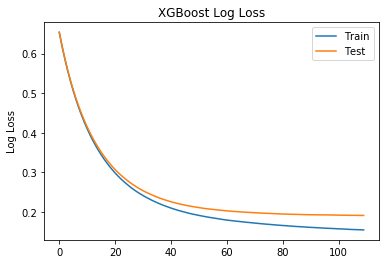

In [125]:
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

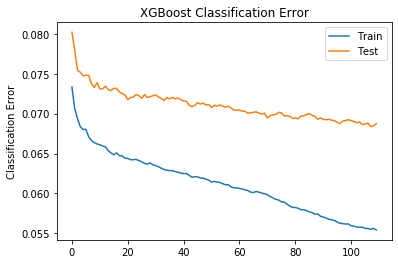

In [126]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [129]:
y_pred_xgb = xgb_model.predict_proba(X_test)
acc_xgb = round(xgb_model.score(X_test, y_test) * 100, 2)
print (acc_xgb)
metrics.roc_auc_score(y_test,y_pred_xgb[:,1])

93.13


0.8964055214544012

In [141]:
for i in [.4, .45,.5,.55, .6]:
    y_pred_class = np.where(y_pred_xgb[:,1] >= i, 1, 0)
#     confusion = metrics.confusion_matrix(y_test, y_pred_class)
    print(metrics.accuracy_score(y_test, y_pred_class))

0.9292373112358938
0.9314724963201221
0.9312544294826365
0.9312544294826365
0.9292373112358938


In [144]:
make_final_preds(xgb_model, 0.07)

In [98]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy import stats

clf_xgb = XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 5,  7, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 25, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)
estimators = []
results = np.zeros(len(X))
score = 0.0
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)

    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    score += metrics.f1_score(y_test, results[test_index])
score /= numFolds

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 60.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 352.1min finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [104]:
best_xgb = estimators[0]
# y_pred_xgb = best_xgb.predict_proba(X_test)

In [127]:
y_pred_xgb = best_xgb.predict_proba(X_test)
acc_xgb = round(best_xgb.score(X_test, y_test) * 100, 2)
print (acc_xgb)
metrics.roc_auc_score(y_test,y_pred_xgb[:,1])

96.85


0.986235782271006

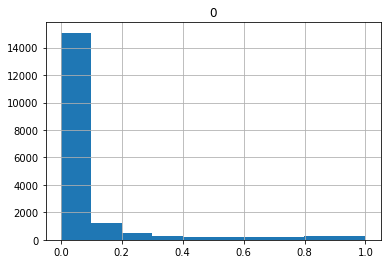

In [108]:
preds = pd.DataFrame(y_pred_xgb[:,1])
hist = preds.hist(bins=10)

In [118]:
# preds.head()
best_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9139582583049244, gamma=0,
              learning_rate=0.052295392520819085, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=486, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3835058649443393, verbosity=1)

In [112]:
preds[preds[0]>0.1].shape[0]/preds.shape[0]

0.177615439132094

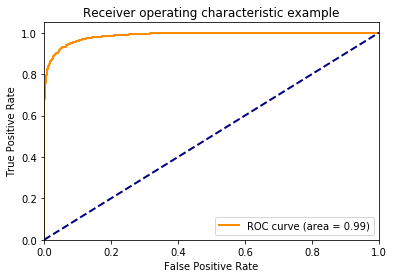

In [105]:
# Plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_xgb[:, 1])
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [117]:
make_final_preds(best_xgb, 0.06)

In [ ]:
from sklearn.model_selection import GridSearchCV

xgb_model = xgboost.XGBClassifier()
optimization_dict = {'max_depth': [2,4,6],
                     'n_estimators': [50,100,200]}

model = GridSearchCV(xgb_model, optimization_dict, 
                     scoring='accuracy', verbose=1)

model.fit(X_train,y_train)
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


### Catboost

In [116]:
from catboost import CatBoostRegressor
cbmodel=CatBoostRegressor(iterations=50, depth=3, learning_rate=0.1, loss_function='RMSE')
cbmodel.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_validation, y_validation),plot=True)

NameError: name 'categorical_features_indices' is not defined